# Urban Heat Islands

In [1]:
%matplotlib inline

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from dask.distributed import Client as DaskClient
import matplotlib.pyplot as plt
import numpy as np
from dream_river.plotimg import display_map
from dream_river.plotimg import rgb

client = DaskClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53343,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.85 GiB
Comm: tcp://127.0.0.1:53371,Total threads: 3
Dashboard: http://127.0.0.1:53372/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:53346,


## Explore study area

In [2]:
# Query bounding box
lat_range = (13.021, 13.148)
lon_range = (100.874, 101.079)

display_map(lon_range,lat_range)

## Set query parameter

In [3]:
#set collection configuration
bbox = [100.874, 13.148, 101.079, 13.021]
start_date = "2022-03-01"
end_date = "2022-04-30"
collections = ["LANDSAT8_ST_C2L2" ,"LANDSAT8_SR_C2L2"]
config = {
    "LANDSAT9_SR_C2L2": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "unitless",
            },
            "aerosol_qa": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "bit",
            },
            "pixel_qa": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "bit",
            },
            "radsat_qa": {
                "data_type": "uint16",
                "units": "bit",
                "nodata": 0,
            },
        },
    }
}

## SR_band (Surface reflectiance band)

In [4]:
# connect to the GISTDA ODC STAC Catalog
catalog = Client.open(url="http://110.78.252.138/stac")
query2 = catalog.search(
    bbox=bbox, collections=collections[1], datetime=f"{start_date}/{end_date}"
)
items2 = list(query2.items())
print(f"Found: {len(items2):d} datasets")
for ds in items2:
    print(ds.to_dict()['properties']['title'])

Found: 8 datasets
LC08_L2SR_128051_20220305_20220314_02_T1
LC08_L2SR_129051_20220312_20220321_02_T1
LC08_L2SR_128051_20220321_20220329_02_T1
LC08_L2SR_129051_20220328_20220405_02_T1
LC08_L2SR_128051_20220406_20220412_02_T1
LC08_L2SR_129051_20220413_20220419_02_T1
LC08_L2SR_128051_20220422_20220428_02_T1
LC08_L2SR_129051_20220429_20220504_02_T1


In [5]:
# Loading data using stac_load()
# ต้อง reset api key ทุกครั้งเพื่อเข้าถึงข้อมูล

configure_rio(GDAL_HTTP_HEADERS="apikey:5kIwCp4IwgjnV1rK5t9rsIhQDXZEUcxh")

ds2 = stac_load(
                items2,
                bands=['red','green', 'blue', 'nir'],
                stac_cfg=config,
                chunks={'time':2, 'x':200, 'y':200},
                groupby="solar_day",
                bbox=bbox,
)
ds2

<xarray.Dataset> Size: 45MB
Dimensions:      (y: 475, x: 746, time: 8)
Coordinates:
  * y            (y) float64 4kB 1.454e+06 1.454e+06 ... 1.44e+06 1.44e+06
  * x            (x) float64 6kB 7.031e+05 7.032e+05 ... 7.255e+05 7.255e+05
    spatial_ref  int32 4B 32647
  * time         (time) datetime64[ns] 64B 2022-03-05T03:31:59 ... 2022-04-29...
Data variables:
    red          (time, y, x) float32 11MB dask.array<chunksize=(2, 200, 200), meta=np.ndarray>
    green        (time, y, x) float32 11MB dask.array<chunksize=(2, 200, 200), meta=np.ndarray>
    blue         (time, y, x) float32 11MB dask.array<chunksize=(2, 200, 200), meta=np.ndarray>
    nir          (time, y, x) float32 11MB dask.array<chunksize=(2, 200, 200), meta=np.ndarray>

In [6]:
# apply rescale factors
red = (ds2.red.isel(time=1) * 0.0000275) + (-0.2)
nir = (ds2.nir.isel(time=1) * 0.0000275) + (-0.2)

## Plot Surface reflectance image

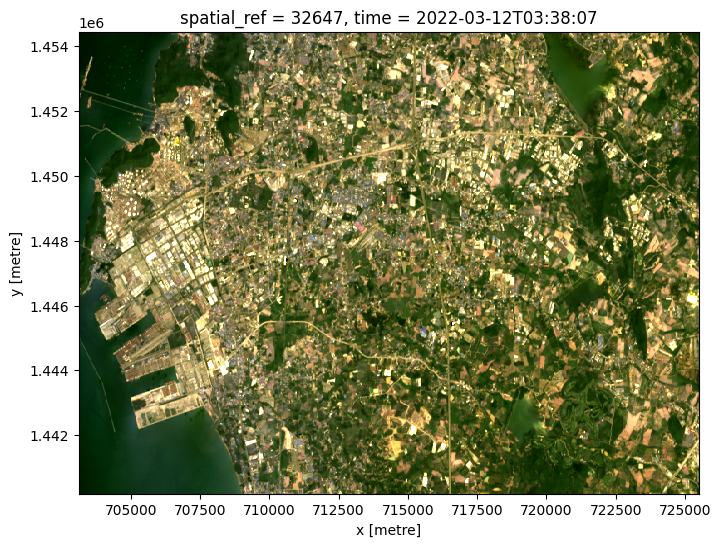

In [7]:
# Plot as an RGB image select first timestep 
rgb(ds2, bands=['red','green', 'blue'], index=[1])

## ST_band (Surface Temperature band)

In [8]:
query = catalog.search(
    bbox=bbox, collections=collections[0], datetime=f"{start_date}/{end_date}"
)
items = list(query.items())
print(f"Found: {len(items):d} datasets")
for ds in items:
    print(ds.to_dict()['properties']['title'])

Found: 8 datasets
LC08_L2ST_128051_20220305_20220314_02_T1
LC08_L2ST_129051_20220312_20220321_02_T1
LC08_L2ST_128051_20220321_20220329_02_T1
LC08_L2ST_129051_20220328_20220405_02_T1
LC08_L2ST_128051_20220406_20220412_02_T1
LC08_L2ST_129051_20220413_20220419_02_T1
LC08_L2ST_128051_20220422_20220428_02_T1
LC08_L2ST_129051_20220429_20220504_02_T1


In [9]:
# Loading data using stac_load()
# ต้อง reset api key ทุกครั้งเพื่อเข้าถึงข้อมูล
configure_rio(GDAL_HTTP_HEADERS="apikey:5kIwCp4IwgjnV1rK5t9rsIhQDXZEUcxh")

ds = stac_load(
                items,
                bands=['tirs1','qa'],
                stac_cfg=config,
                chunks={'time':2, 'x':200, 'y':200},
                groupby="solar_day",
                bbox=bbox,
)
ds

<xarray.Dataset> Size: 23MB
Dimensions:      (y: 475, x: 746, time: 8)
Coordinates:
  * y            (y) float64 4kB 1.454e+06 1.454e+06 ... 1.44e+06 1.44e+06
  * x            (x) float64 6kB 7.031e+05 7.032e+05 ... 7.255e+05 7.255e+05
    spatial_ref  int32 4B 32647
  * time         (time) datetime64[ns] 64B 2022-03-05T03:31:59 ... 2022-04-29...
Data variables:
    tirs1        (time, y, x) float32 11MB dask.array<chunksize=(2, 200, 200), meta=np.ndarray>
    qa           (time, y, x) float32 11MB dask.array<chunksize=(2, 200, 200), meta=np.ndarray>

## Plot Surface temperature image

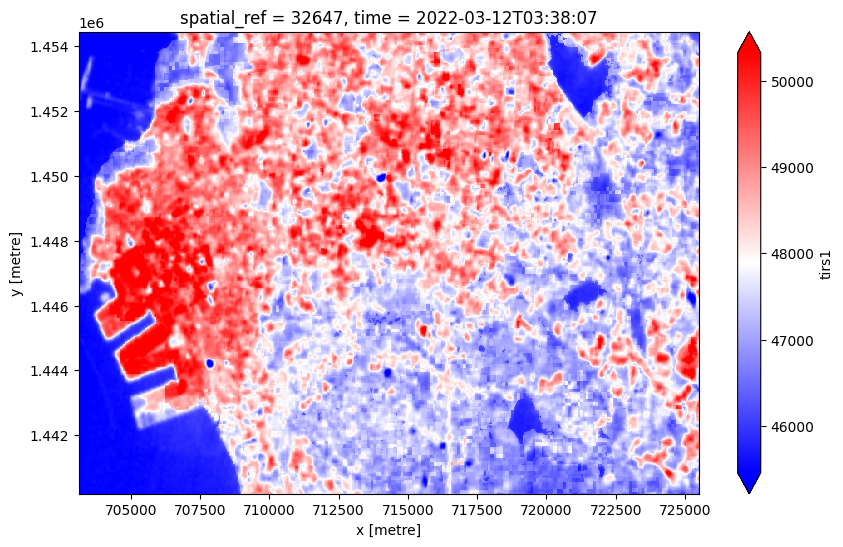

In [10]:
band10 = ds.tirs1.isel(time=1)
band10.plot(cmap='bwr', figsize=(10, 6), robust = 'True')

## Calculate Land Surface Temperature (LST)

The script calculates Land Surface Temperature (LST) using Planck’s Law. The formula is provided as a mathematical expression. It involves using the thermal band and emissivity (em) values to compute LST.

[Reference](https://medium.com/@ridhomuh002/analyzing-land-surface-temperature-lst-with-landsat-8-data-in-google-earth-engine-f4dd7ca28e70)

### The thermal band

The script selects the thermal band (Band 10) from the input image. This band contains thermal infrared information.

In [11]:
# apply rescale factors(convert Kelvin to Celsius)
Thermalband = ((0.00341802 * band10) + 149) -273.15

print(np.max(Thermalband).values)
print(np.min(Thermalband).values)

57.53485
23.105133


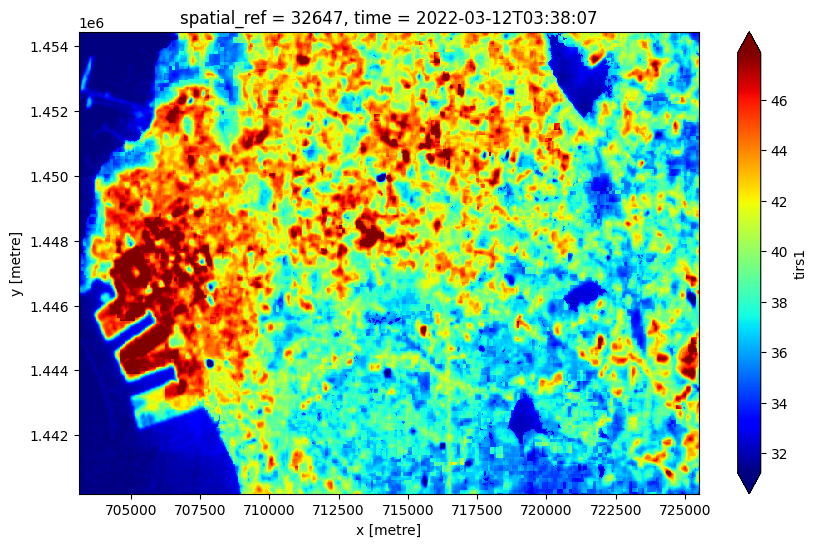

In [12]:
Thermalband.plot(cmap='jet', figsize=(10, 6), robust = 'True')

### Normalized Difference Vegetation Index (NDVI)

In [13]:
NDVI = (nir - red)/(nir + red)

NDVI_max = np.max(NDVI).values
NDVI_min = np.min(NDVI).values

print(np.max(NDVI).values)
print(np.min(NDVI).values)


1.4614301
-0.5091553


### Proportion of Vegetation (PV)

The Proportion of Vegetation (PV) is a metric used to quantify the relative abundance of vegetation within a specified area by analyzing Normalized Difference Vegetation Index (NDVI) values. It provides valuable insights into land cover and ecosystem health, with higher PV values indicating a greater presence of vegetation. On the other hand, Emissivity (EM) is a critical parameter for accurate Land Surface Temperature (LST) calculations. In the provided code, EM is computed as a function of PV, reflecting how efficiently a surface emits thermal radiation. EM values near 1.0 are typical for natural surfaces like soil and vegetation, while lower values are often associated with water bodies or urban areas. Both PV and EM play essential roles in remote sensing and environmental studies, contributing to a more comprehensive understanding of land characteristics and thermal behavior.

In [14]:
PV = np.square((NDVI - NDVI_min) / (NDVI_max - NDVI_min))

### Emissivity (EM)

In [15]:
EM = 0.004 * PV + 0.986

### Land Surface Temperature (LST)
  formula : LST = (Thermalband / (1 + (0.00115 * (Thermalband / 1.4388)) * log(EM)))

In [16]:
LST = Thermalband/(1 + (0.00115 * Thermalband)/ 1.4388 * np.log(EM)) 

LST_mean = LST.mean()
LST_std = LST.std()
LST_max = LST.max()
LST_min = LST.min()

print('STD: ', LST_std.values)
print('Mean: ',LST_mean.values)
print('Max: ', LST_max.values)
print('Min: ',LST_min.values)


STD:  4.2142057
Mean:  39.378254
Max:  57.57125
Min:  23.110992


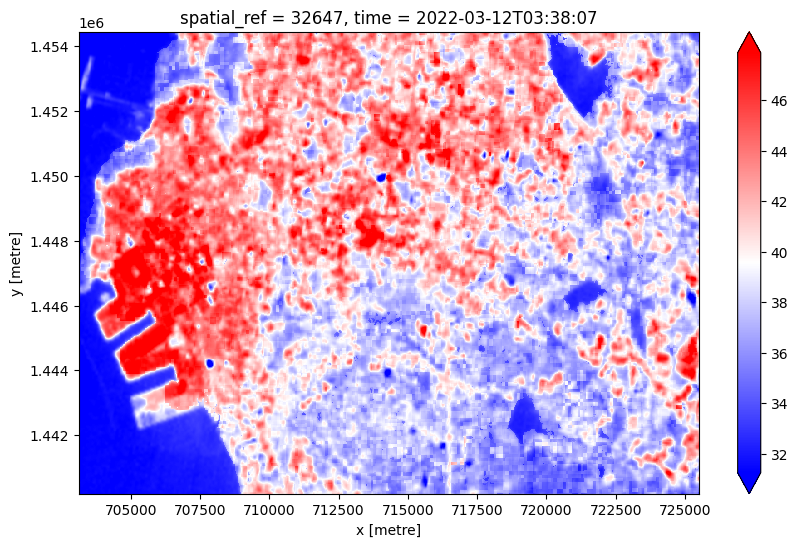

In [17]:
LST.plot(cmap='bwr', figsize=(10, 6), robust = 'True')


## Urban Heat Islands (UHI)

### UHI = (LST - LST_mean) / LST_STD


| Type    | UHI value range | Class |
| -------- | ------- |------- |
| 1  | <0.07    |Very weak heat island    |
| 2 | 0.08–0.12     |Weak heat island     |
| 3    | 0.13–0.17    |Moderate heat island    |
| 4    | 0.18–0.20    |Strong heat island    |
| 5    | >0.21    |Very strong heat island    |

In [18]:
UHI = (LST - LST_mean.values)/ LST_std.values

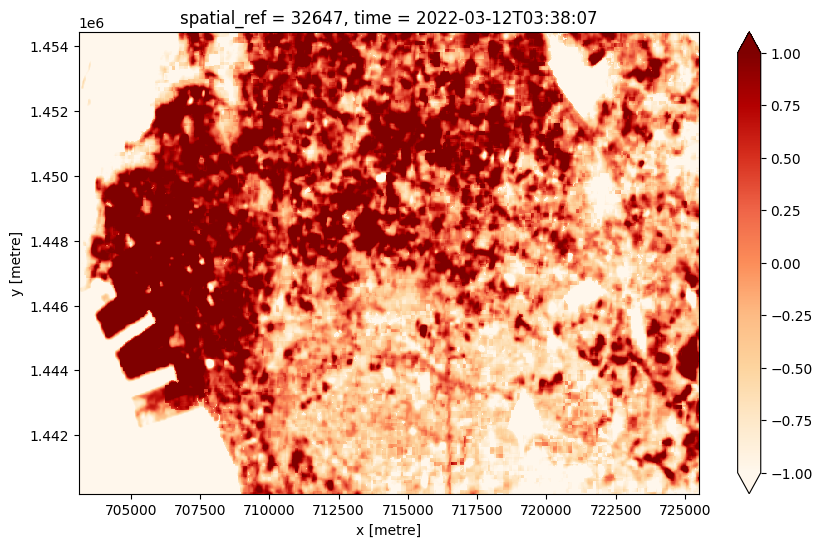

In [19]:
UHI.plot( vmin=-1, vmax=1, cmap='OrRd', figsize=(10, 6), robust = 'True')